# Download Data

In [1]:
!wget http://commachallenge.s3-us-west-2.amazonaws.com/speed_challenge_2017.tar
!tar -xvf /content/speed_challenge_2017.tar
!mkdir data/frames

--2019-03-19 05:28:16--  http://commachallenge.s3-us-west-2.amazonaws.com/speed_challenge_2017.tar
Resolving commachallenge.s3-us-west-2.amazonaws.com (commachallenge.s3-us-west-2.amazonaws.com)... 52.218.128.113
Connecting to commachallenge.s3-us-west-2.amazonaws.com (commachallenge.s3-us-west-2.amazonaws.com)|52.218.128.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197191680 (188M) [application/x-tar]
Saving to: ‘speed_challenge_2017.tar.1’

speed_challenge_201 100%[===================>] 188.06M  21.7MB/s    in 9.5s    

2019-03-19 05:28:26 (19.7 MB/s) - ‘speed_challenge_2017.tar.1’ saved [197191680/197191680]

README
data/
data/train.mp4
data/test.mp4
data/train.txt


# Exploring Data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

data_df = pd.read_csv('/content/data/train.txt', header=None)
print(data_df.head(10))

speeds = data_df.values

print('\nStatistics of Speed Distribution')
print(scipy.stats.describe(speeds))

plt.figure(figsize=(20,10))
plt.title('Speed vs Time of the vehicle')
plt.plot(speeds)
plt.xlabel('time')
plt.ylabel('Speed')
plt.show()


print("\nHistogram of speed distribution")
plt.hist(speeds)
plt.show()

## Video frames to images

In [0]:
import cv2

vidcap = cv2.VideoCapture('/content/data/train.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("/content/data/frames/%d.jpg" % count, image)    
  success,image = vidcap.read()
  count += 1

In [0]:
# utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# get image index with path as input
def get_image_idx(path):
  idx = path.split('/')[4].split('.')[0]
  return int(idx)

# get speed from txt with idx
data_df = pd.read_csv('/content/data/train.txt', header=None)
def get_speed(idx):
  return data_df.iloc[idx][0]
  
def view_img_speed(img_path):
#   img_path = '/content/data/frames/'+frames_list[0]
  print(img_path)
  img = mpimg.imread(img_path)
  print(img.shape)
  plt.text(100,100,'speed = '+str(get_speed(get_image_idx(img_path))), fontsize=20, color='yellow')
  plt.imshow(img)
  plt.grid(False)
  plt.show()

/content/data/frames/200.jpg
(480, 640, 3)


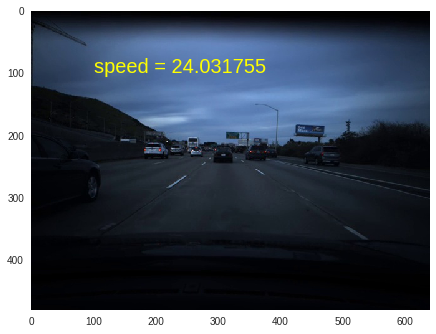

/content/data/frames/201.jpg
(480, 640, 3)


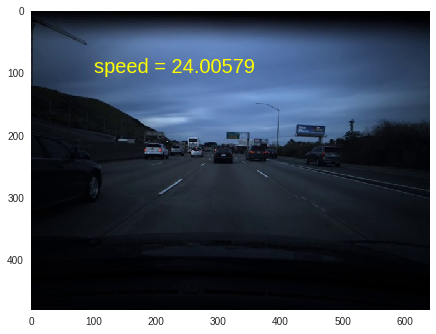

/content/data/frames/202.jpg
(480, 640, 3)


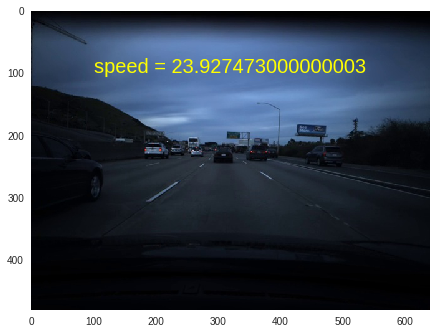

/content/data/frames/203.jpg
(480, 640, 3)


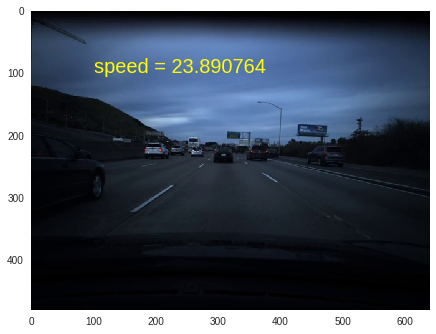

/content/data/frames/204.jpg
(480, 640, 3)


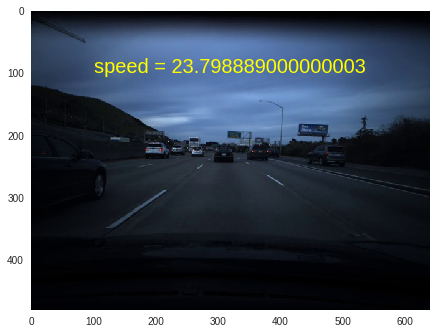

In [6]:
for i in range(200,205):
  img_path = '/content/data/frames/'+str(i)+'.jpg'
  view_img_speed(img_path)

# Raw Data to Numpy to Tensors

0 28.105569
/content/data/frames/0.jpg
(480, 640, 3)


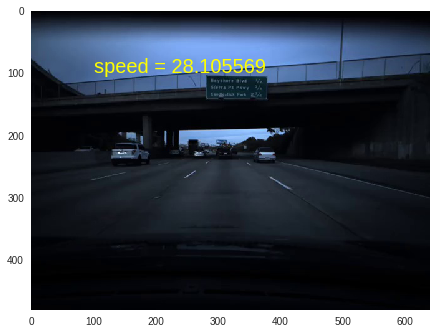

1 28.105569
/content/data/frames/1.jpg
(480, 640, 3)


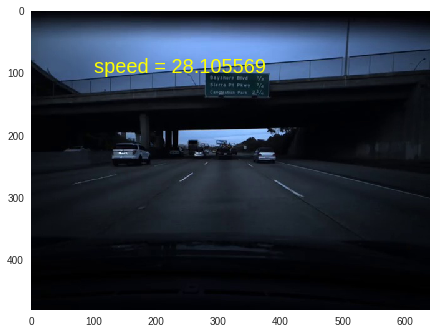

2 28.106527000000003
/content/data/frames/2.jpg
(480, 640, 3)


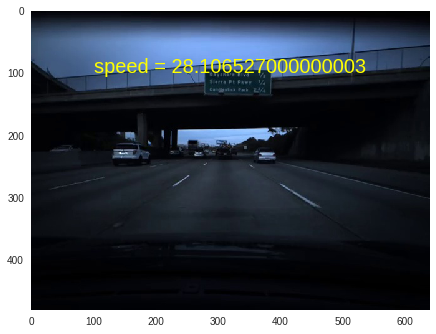

3 28.130404
/content/data/frames/3.jpg
(480, 640, 3)


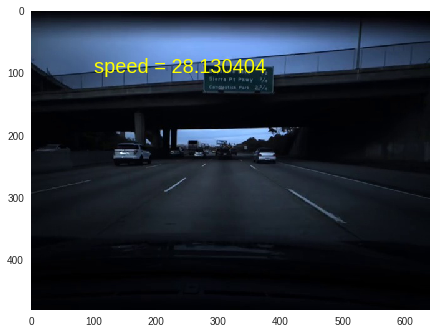

4 28.109243
/content/data/frames/4.jpg
(480, 640, 3)


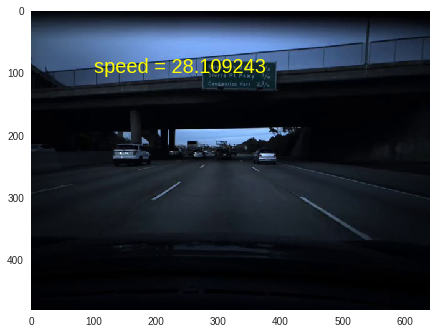

5 28.088571999999996
/content/data/frames/5.jpg
(480, 640, 3)


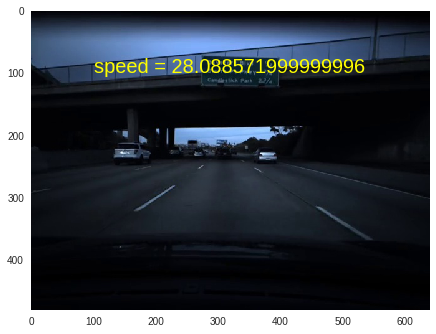

In [7]:
for i, row in data_df.iterrows():
  print(i, row[0])
  img_path = "/content/data/frames/{}.jpg".format(i)
  view_img_speed(img_path)
  if i>=5:break

## 480 x 640 is computationally expensive(atleast for GPU i am using) and also the sky and road doesn't give much information regarding the speed.

The speed of the vehicle will be calculated by the relative distance of the vehicle form other, so its better to remove unnecessary data from the image.

I am cropping 220x220 from center which will contain most of the necessary data. Range can be increased for better performance but due to my GPU Memory , i will stick to 240x240 , will increase it if possible later.

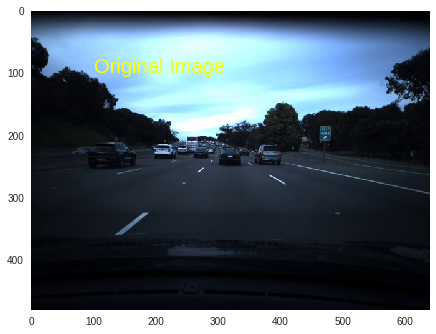

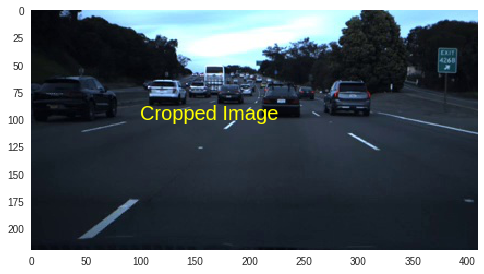

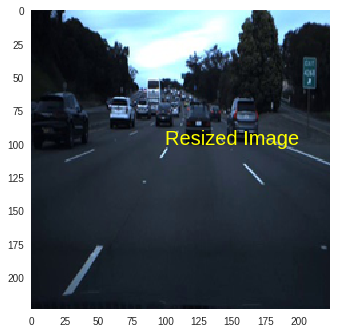

In [2]:
from PIL import Image


img = Image.open("/content/data/frames/1000.jpg")


img1 = img.crop((90,150,500,370))
# [130:350,210:450]
plt.imshow(img)
plt.text(100,100,'Original Image', fontsize=20, color='yellow')
plt.grid(False)
plt.show()

plt.imshow(img1)
plt.text(100,100,'Cropped Image', fontsize=20, color='yellow')
plt.grid(False)
plt.show()

import numpy as np
img2 = img1.resize((224,224), Image.ANTIALIAS)

plt.imshow(img2)
plt.text(100,100,'Resized Image', fontsize=20, color='yellow')
plt.grid(False)
plt.show()



def crop_resize_img(img):
  img = img.crop((90,150,500,370))
  img = img.resize((224,224), Image.ANTIALIAS)
  return img

0 speed = 28.105569


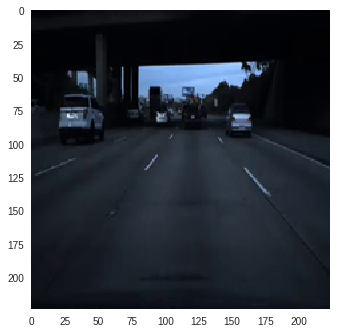

1 speed = 28.105569


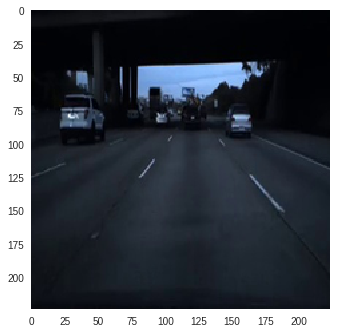

2 speed = 28.106527000000003


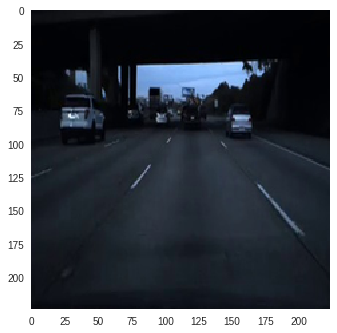

3 speed = 28.130404


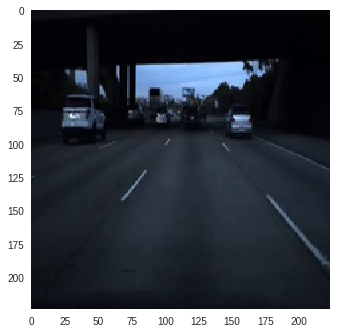

In [3]:
for i, row in data_df.iterrows():
  print(i, 'speed = {}'.format(row[0]))
  img_path = "/content/data/frames/{}.jpg".format(i)
  img = Image.open(img_path)
  final_img = crop_resize_img(img)
  plt.imshow(final_img)
  plt.grid(False)
  plt.show()
  if i>=3 :break

## PIL image to Tensors

## Standardizing labels to improve convergence

In [0]:
import torch
from PIL import Image
import numpy as np
imgs = []
labels = []

valid_imgs = []
valid_labels = []

for i, row in data_df.iterrows():
  img_path = "/content/data/frames/{}.jpg".format(i)
  img = Image.open(img_path)
  img = crop_resize_img(img)
  if i < 16320:
    imgs.append(np.array(img))
    labels.append(row[0])
  else:
    valid_imgs.append(np.array(img))
    valid_labels.append(row[0])
    
    

imgs = np.array(imgs)
labels = np.array(labels)

valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)




In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(labels.reshape(-1,1))
labels = scaler.transform(labels.reshape(-1,1))
# scaler.inverse_transform(scaled_data[0].reshape(1, -1))  

In [13]:
np.max(valid_labels)

28.130404

## Train test split of data

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test ,y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=12)

In [0]:
%whos

Variable           Type         Data/Info
-----------------------------------------
Image              module       <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
crop_resize_img    function     <function crop_resize_img at 0x7fc8c7294268>
data_df            DataFrame                   0\n0      <...>n[20400 rows x 1 columns]
i                  int          20399
img                Image        <PIL.Image.Image image mo<...>24x224 at 0x7FC87DBB5EF0>
img_path           str          /content/data/frames/20399.jpg
imgs               ndarray      20400x224x224x3: 3070771200 elems, type `uint8`, 3070771200 bytes (2928.515625 Mb)
labels             ndarray      20400: 20400 elems, type `float64`, 163200 bytes (159.375 kb)
np                 module       <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
pd                 module       <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt                module       <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
r

In [0]:
del imgs, labels 

## Numpy Array -> Tensor -> DataLoader

In [0]:
import torch.utils.data as utils
from torchvision import transforms
 

# normalize=  transforms.Compose([
#      transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#  ])


# tensor_x = torch.from_numpy(np.array(np.rollaxis(x_train, 3, 1)))
# tensor_x = torch.stack([normalize(img) for img in tensor_x])


# tensor_xte = torch.from_numpy(np.array(np.rollaxis(x_test, 3, 1)))
# tensor_xte = torch.stack([normalize(img) for img in tensor_xte])




tensor_x = torch.from_numpy(np.rollaxis(imgs, 3, 1))
tensor_y = torch.from_numpy(labels)
my_dataset = utils.TensorDataset(tensor_x, tensor_y)
trainloader = utils.DataLoader(my_dataset, batch_size = 1300)

tensor_xte = torch.from_numpy(np.rollaxis(valid_imgs, 3, 1))
tensor_yte = torch.from_numpy(valid_labels)
my_datasette = utils.TensorDataset(tensor_xte, tensor_yte)
testloader = utils.DataLoader(my_datasette, batch_size = 500)

In [0]:
del labels, imgs, valid_imgs, valid_labels

In [7]:
tensor_x.shape

torch.Size([16320, 3, 224, 224])

## Model Tranfer Learning

In [8]:
from torchvision import models

model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
for param in model.layer4[1].parameters():
    param.requires_grad = True
    
for param in model.fc.parameters():
    param.requires_grad = True    
    
for param in model.avgpool.parameters():
    param.requires_grad = True

In [0]:
# for params in model.features[6:].parameters():
#     param.requires_grad = True  

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
class NeuralAccumulator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(NeuralAccumulator, self).__init__()
        self.W1 = Parameter(torch.Tensor(out_dim, in_dim))
        self.W2 = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)
        
        self.W = Parameter(torch.tanh(self.W1) * torch.sigmoid(self.W2))
        
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)
        
    def forward(self, x):
        out = nn.functional.linear(x, self.W, self.bias)
        return out
      
      
class NALU(nn.Module):
    def __init__(self, in_dim, out_dim, e=1e-1):
        super(NALU, self).__init__()
        self.e = e
        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('Gbias', None)
        self.register_parameter('Wbias', None)
        self.nac = NeuralAccumulator(in_dim, out_dim)
        
        nn.init.xavier_uniform_(self.G)
        nn.init.xavier_uniform_(self.W)
        
    def forward(self, x):
        a = self.nac(x)
        g = torch.sigmoid(nn.functional.linear(x, self.G, self.Wbias))
        m = torch.sigmoid(nn.functional.linear(torch.log(torch.abs(x) + self.e), self.W, self.Wbias))
        out = g*a + (1-g)*m
        return out

In [13]:
import torch.nn as nn

# last_layer = nn.Sequential(nn.Linear(4096, 1),nn.Tanh())
classifier = nn.Sequential(NALU(512, 256),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           NALU(256, 1),
                           nn.ReLU())
# model.classifier[6] = last_layer
model.fc = classifier
model.cuda()
print(model.fc)

Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=256, out_features=1, bias=True)
  (4): ReLU()
)


In [14]:
model(torch.randn(1,3,224,224).cuda())

tensor([[0.]], device='cuda:0', grad_fn=<ThresholdBackward0>)

In [0]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training loop

In [0]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
valid_loss_min = np.Inf
epochs = 50
steps = 0
# valid_loss_min = np.Inf

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    tr_accuracy = 0
    for images, labels in trainloader:
        images = (images.type(torch.FloatTensor).cuda()-128)/255
        labels = labels.type(torch.FloatTensor).cuda()
        optimizer.zero_grad()
#         print(images.type())
#         print(images)
        log_ps  = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images = (images.type(torch.FloatTensor).cuda()-128)/255
                labels = labels.type(torch.FloatTensor).cuda()
                log_ps = model(images)
#                 print(log_ps)
                test_loss += criterion(log_ps, labels)

        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{} ".format(e+1, epochs),
              "Training Loss: {:.3f} ".format(train_losses[-1]),
              "Test Loss: {:.3f} ".format(test_losses[-1]))
        if test_loss/len(testloader) <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          test_loss/len(testloader)))
          torch.save(model.state_dict(), 'best_model.pt')
          valid_loss_min = test_loss/len(testloader)
        
plt.plot(train_losses, 'b', label='Training Loss')
plt.plot(test_losses, 'r', label='Validation Loss')
plt.show()

Epoch: 1/50  Training Loss: 187.172  Test Loss: 71.617 
Validation loss decreased (inf --> 71.616531).  Saving model ...
Epoch: 2/50  Training Loss: 78.437  Test Loss: 64.675 
Validation loss decreased (71.616531 --> 64.675285).  Saving model ...
Epoch: 3/50  Training Loss: 69.899  Test Loss: 58.101 
Validation loss decreased (64.675285 --> 58.101490).  Saving model ...
Epoch: 4/50  Training Loss: 66.001  Test Loss: 74.521 
Epoch: 5/50  Training Loss: 53.935  Test Loss: 75.077 
Epoch: 6/50  Training Loss: 45.007  Test Loss: 65.949 
Epoch: 7/50  Training Loss: 37.452  Test Loss: 70.489 
Epoch: 8/50  Training Loss: 32.069  Test Loss: 49.574 
Validation loss decreased (58.101490 --> 49.574017).  Saving model ...
Epoch: 9/50  Training Loss: 30.394  Test Loss: 55.946 


In [0]:
with torch.no_grad():
  model.eval()
  for images, labels in testloader:
      images = (images.type(torch.FloatTensor).cuda()-128)/255
      labels = labels.type(torch.FloatTensor).cuda()
      log_ps = model(images)
      print(log_ps)
      print(labels)
      break

tensor([[12.2230],
        [12.0778],
        [12.2803],
        [12.2132],
        [12.1145],
        [12.2055],
        [12.0980],
        [12.1094],
        [12.1819],
        [12.1372],
        [12.1189],
        [12.1824],
        [12.1243],
        [12.2234],
        [12.1625],
        [12.1495],
        [12.2921],
        [12.2090],
        [12.1839],
        [12.1537],
        [12.2335],
        [12.2260],
        [12.1527],
        [12.1108],
        [12.1036],
        [12.0507],
        [12.1259],
        [12.1586],
        [12.2359],
        [12.1892],
        [12.0177],
        [12.1679],
        [12.1356],
        [12.1583],
        [12.0972],
        [12.1315],
        [12.1268],
        [12.0628],
        [12.0831],
        [12.1057],
        [12.1489],
        [12.0651],
        [12.1167],
        [12.1240],
        [12.2716],
        [12.2049],
        [12.1164],
        [12.1388],
        [12.2078],
        [12.1806],
        [12.1375],
        [12.0377],
        [12.